# <font color='green'> BigMart Sales Prediction Project

# Author:Paula Samir

# Summary

## This project predict the sales based on some feature like the Outlet location,size,Establishment year ,the type of the outlet,the maximum retail price either the item is low fat or regular and the type of the item

### Columns Description
#### Item_Identifier: Unique product ID
#### Item_Weight: Weight of product
#### Item_Fat_Content: Whether the product is low fat or not
#### Item_Visibility: The % of total display area of all products in a store allocated to the particular product
#### Item_Type: The category to which the product belongs
#### Item_MRP: Maximum Retail Price (list price) of the product
#### Outlet_Identifier: Unique store ID
####  Outlet_Establishment_Year: The year in which store was established
####  Outlet_Size: The size of the store in terms of ground area covered
####  Outlet_Location_Type: The type of city in which the store is located
####  Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket
####  Item_Outlet_Sales: Sales of the product in the particulat store. This is the outcome variable to be predicted.

##  Data cleaning :
### 1- I use the column of establishment year to get the number of year from 2013
### 2- I found that there is a outliers in Item_visiblity column so i use to drop it 
### 3- I found in the Item_fat_content there is a multiple type have the smae meaning but different in the syntax
### 4- I found in the item_visiblity column there a value equal to zero so i impute this values by the mean of the value with respect to the Item_type
### 5- I fix the outlet_size column by filling the null value with high as it is the lowest repeatable value
### 6- I fill the item_weight null values with the mean as i found it has a small correlation with other feature 


## Data Preprocessing:
### I used StandardScaler to scale the numerical data as it appeared in the plot to be the most fitted data to each other. Then, I used label encoding to transform the categorical data. I tried many models, but the best score I obtained was with GradientBoostingRegressor after applying GridSearch for hyperparameter tuning.

In [1]:
# importings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler , MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error ,r2_score , mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso,Ridge
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Train.csv')

In [3]:
test_data=pd.read_csv('Test.csv')

In [4]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
def check_data_is_clean(df):
    check_missing_values=(df.isna().sum()).sum()
    check_dublicates=df.duplicated().sum()
    if check_missing_values==0 and check_dublicates ==0:
        return print('\033[1m The Data has no Missing values and no Dublicated values\033[0m ,','The shape of the data',df.shape)
    else:
        return print('\033[1mThe Data has {} Missing values and {} Dublicated values ,'.format(check_missing_values,check_dublicates),'The shape of the data',df.shape)
    

In [6]:
# train_data
check_data_is_clean(df)

The Data has 3873 Missing values and 0 Dublicated values , The shape of the data (8523, 12)


In [7]:
# test_data
check_data_is_clean(test_data)

The Data has 2582 Missing values and 0 Dublicated values , The shape of the data (5681, 11)


In [8]:
(df.isna().sum()).sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
(test_data.isna().sum()).sort_values(ascending=False)

Outlet_Size                  1606
Item_Weight                   976
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [10]:
# get the index of na values in Outlet_size columns
na_index_in_outlet_size=df[df['Outlet_Size'].isna()].index

In [11]:
# get the index of na values in Item_weight columns
na_index_in_Item_Weight=df[df['Item_Weight'].isna()].index

In [12]:
# to insure that there's no row contain two na values in the two columns that conatin na_values
commen_na_index=[]
for i in na_index_in_Item_Weight:
    if i in na_index_in_outlet_size:
        commen_na_index.append(i)
commen_na_index

[]

In [13]:
##  to calculate the the number of year of establishment 
df['No_Establishment_Years']=2013-df['Outlet_Establishment_Year']

In [14]:
test_data['No_Establishment_Years']=2013-test_data['Outlet_Establishment_Year']

<AxesSubplot:>

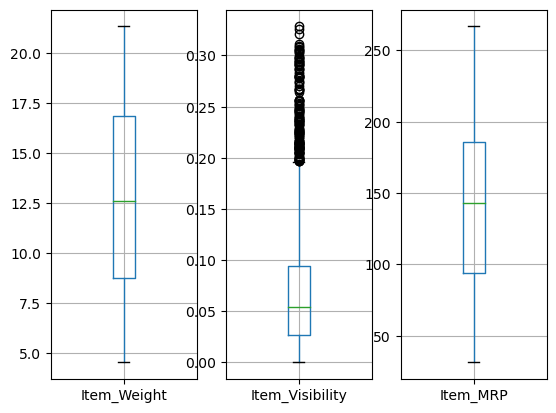

In [15]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols = 3,)
df.boxplot(column='Item_Weight',ax=ax1)
df.boxplot(column='Item_Visibility',ax=ax2)
df.boxplot(column='Item_MRP',ax=ax3)


df['Item_Visibility'] = winsorize(df['Item_Visibility'], limits=[0.05, 0.05])

In [16]:
# train_data
q1_tarin=df['Item_Visibility'].quantile(0.25)
q3_train=df['Item_Visibility'].quantile(0.75)
IQR_train=q3_train-q1_tarin
upper=q3_train+1.5*IQR_train
lower=q1_tarin-1.5*IQR_train
upper_array=np.where(df['Item_Visibility']>=upper)[0]
lower_array=np.where(df['Item_Visibility']<=lower)[0]
df.drop(index=upper_array,inplace=True)
df.drop(index=lower_array,inplace=True)
df.reset_index(drop=True,inplace=True)

<AxesSubplot:>

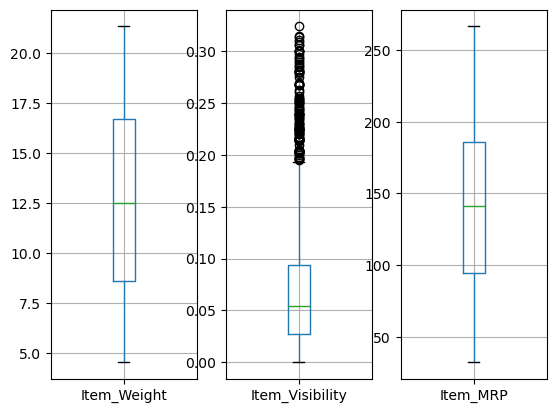

In [17]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols = 3,)
test_data.boxplot(column='Item_Weight',ax=ax1)
test_data.boxplot(column='Item_Visibility',ax=ax2)
test_data.boxplot(column='Item_MRP',ax=ax3)



test_data['Item_Visibility'] = winsorize(test_data['Item_Visibility'], limits=[0.05, 0.05])

In [18]:
# test_data
q1_test=test_data['Item_Visibility'].quantile(0.25)
q3_test=test_data['Item_Visibility'].quantile(0.75)
IQR_test=q3_test-q1_test
upper_test=q3_test+1.5*IQR_test
lower_test=q1_test-1.5*IQR_test
upper_array_test=np.where(test_data['Item_Visibility']>=upper_test)[0]
lower_array_test=np.where(test_data['Item_Visibility']<=lower_test)[0]
test_data.drop(index=upper_array_test,inplace=True)
test_data.drop(index=lower_array_test,inplace=True)
test_data.reset_index(drop=True,inplace=True)

# ----------------------------------------------------------------------------------------------------------
## fix Item_fat_content column


In [19]:
#we found by explore the item fat content column that there are only two unique values (low_fat,regular) but it saved in different ways

df.Item_Fat_Content.unique()


array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [20]:
# fix fat content column 
# convert them to lowercase letter
df['Item_Fat_Content']=df.Item_Fat_Content.apply(lambda x:x.lower())
# convert the 'low fat' to 'lf' and'regular' to 'reg'
df['Item_Fat_Content']=df['Item_Fat_Content'].apply(lambda x:'lf' if x=='low fat' else('reg' if x=='regular' else x) )
df['Item_Fat_Content']=df['Item_Fat_Content'].apply(lambda x:'lf' if x=='low fat' else('reg' if x=='regular' else x) )

In [21]:
df.Item_Fat_Content.unique()

array(['lf', 'reg'], dtype=object)

In [22]:
# fix Item_fat_content in test data
test_data['Item_Fat_Content']=test_data.Item_Fat_Content.apply(lambda x:x.lower())
# convert the 'low fat' to 'lf' and'regular' to 'reg'
test_data['Item_Fat_Content']=test_data['Item_Fat_Content'].apply(lambda x:'lf' if x=='low fat' else('reg' if x=='regular' else x) )
test_data['Item_Fat_Content']=test_data['Item_Fat_Content'].apply(lambda x:'lf' if x=='low fat' else('reg' if x=='regular' else x) )

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>

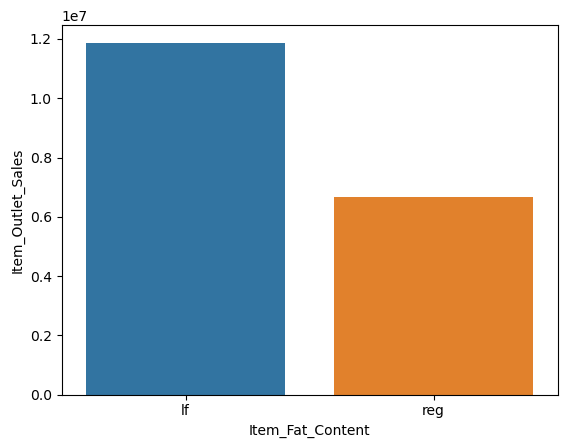

In [23]:
sales_by_fat_content = df.groupby('Item_Fat_Content')['Item_Outlet_Sales'].sum().reset_index()

# Create a bar plot
sns.barplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=sales_by_fat_content)

# ---------------------------------------------------------------------------------------------

## fix issuse in item visiblity column

In [24]:
df[df['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,No_Establishment_Years
3,FDX07,19.200,reg,0.0,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,15
4,NCD19,8.930,lf,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,26
5,FDP36,10.395,reg,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088,4
10,FDY07,11.800,lf,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266,14
32,FDP33,18.700,lf,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8337,FDQ58,NaN,lf,0.0,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020,28
8341,DRJ49,6.865,lf,0.0,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736,26
8343,FDR20,20.000,reg,0.0,Fruits and Vegetables,46.4744,OUT010,1998,NaN,Tier 3,Grocery Store,45.2744,15
8351,NCI54,15.200,lf,0.0,Household,110.4912,OUT017,2007,NaN,Tier 2,Supermarket Type1,1637.8680,6


In [25]:
x=df[df['Item_Visibility']==0].index

In [26]:
# we make a new copy to drop the row that has a zero on the item_visbility and compute the mean of each type to be more accurete
df1=df.copy()

In [27]:
df1=df1.drop(index=x,axis=0)

In [28]:
# we convert the zero's value to na 
df['Item_Visibility']=df['Item_Visibility'].apply(lambda x: np.nan if x==float(0) else x)

In [29]:
test_data['Item_Visibility']=test_data['Item_Visibility'].apply(lambda x: np.nan if x==float(0) else x)

In [30]:
mean_visibilty_of_each_type={}
for i in df1['Item_Type'].unique():
    mean_visibilty_of_each_type.update({str(i):df1[df1['Item_Type']==str(i)]['Item_Visibility'].mean()})

In [31]:
mean_visibilty_of_each_type

{'Dairy': 0.07342324057436712,
 'Soft Drinks': 0.06658225818518526,
 'Meat': 0.0621209671256281,
 'Snack Foods': 0.06787375602875118,
 'Frozen Foods': 0.06729687016120903,
 'Fruits and Vegetables': 0.06998818710080294,
 'Breakfast': 0.08183052610679616,
 'Health and Hygiene': 0.05745286363975154,
 'Hard Drinks': 0.06787122299484535,
 'Baking Goods': 0.06967515476962446,
 'Household': 0.06205401157919618,
 'Canned': 0.06881568605785124,
 'Breads': 0.06859509098268399,
 'Starchy Foods': 0.0693528548125,
 'Others': 0.06224413243949046,
 'Seafood': 0.07126387291228069}

In [32]:
## then we fill the na value with the mean of each type visiblity 
df['Item_Visibility'].fillna(df['Item_Type'].apply(lambda x: mean_visibilty_of_each_type.get(x)),inplace=True)

In [33]:
test_data['Item_Visibility'].fillna(test_data['Item_Type'].apply(lambda x: mean_visibilty_of_each_type.get(x)),inplace=True)

<AxesSubplot:>

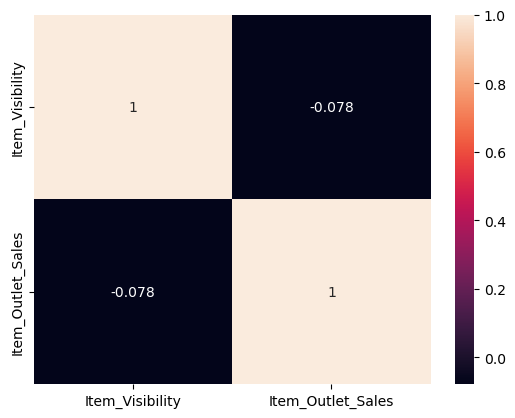

In [34]:
sns.heatmap(df[['Item_Visibility','Item_Outlet_Sales']].corr(),annot=True)

## ---------------------------------------------------------------------------------------------

## <font color='green'> fix Outlet_Size columns

In [35]:
test_data.Outlet_Establishment_Year.sort_values(ascending=True).unique()

array([1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009], dtype=int64)

In [36]:
df.Outlet_Establishment_Year.sort_values(ascending=True).unique()

array([1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009], dtype=int64)

In [37]:
for i in test_data['Outlet_Establishment_Year'].sort_values(ascending=True).unique():
    print('\033[1mtest_data\033[0m',i,test_data[test_data['Outlet_Establishment_Year']==i]['Outlet_Size'].isna().value_counts())
    print('\033[1mtest_data\033[0m',i,test_data[test_data['Outlet_Establishment_Year']==i]['Outlet_Size'].value_counts())
    print('\033[1mTrain_data\033[0m',i,df[df['Outlet_Establishment_Year']==i]['Outlet_Size'].isna().value_counts())
    
    print('\033[1mTrain_data\033[0m',i,df[df['Outlet_Establishment_Year']==i]['Outlet_Size'].value_counts())
    print('-'*50)
# we notice that the na values in this column in train data is the same in test data 

test_data 1985 False    920
Name: Outlet_Size, dtype: int64
test_data 1985 Medium    624
Small     296
Name: Outlet_Size, dtype: int64
Train_data 1985 False    1386
Name: Outlet_Size, dtype: int64
Train_data 1985 Medium    935
Small     451
Name: Outlet_Size, dtype: int64
--------------------------------------------------
test_data 1987 False    621
Name: Outlet_Size, dtype: int64
test_data 1987 High    621
Name: Outlet_Size, dtype: int64
Train_data 1987 False    932
Name: Outlet_Size, dtype: int64
Train_data 1987 High    932
Name: Outlet_Size, dtype: int64
--------------------------------------------------
test_data 1997 False    620
Name: Outlet_Size, dtype: int64
test_data 1997 Small    620
Name: Outlet_Size, dtype: int64
Train_data 1997 False    930
Name: Outlet_Size, dtype: int64
Train_data 1997 Small    930
Name: Outlet_Size, dtype: int64
--------------------------------------------------
test_data 1998 True    313
Name: Outlet_Size, dtype: int64
test_data 1998 Series([], Name: O

In [38]:
df['Outlet_Size'].value_counts()

Medium    2793
Small     2311
High       932
Name: Outlet_Size, dtype: int64

<AxesSubplot:xlabel='Outlet_Size', ylabel='Outlet_Identifier'>

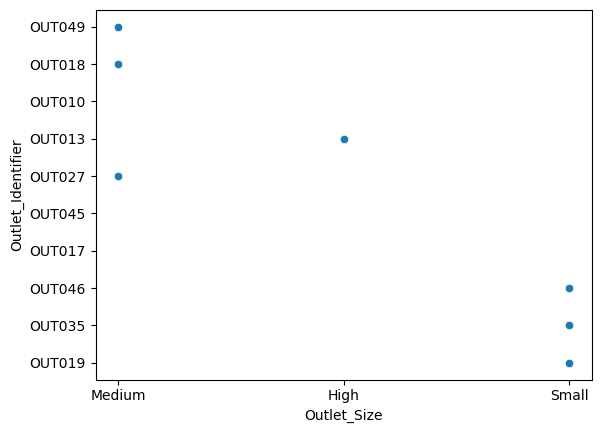

In [39]:
sns.scatterplot(x=df['Outlet_Size'],y=df['Outlet_Identifier'])

In [40]:
# we notice that the medium and small oulet size is nearly have the same counts but the hight outlet_size is the least number 
## so we will fill the null values in outlet_size with high
df['Outlet_Size'].fillna('High',inplace=True)
test_data['Outlet_Size'].fillna('High',inplace=True)

# -------------------------------------------------------------------------------------------------

## <font color ='red'> fix Item_Weigh column

<AxesSubplot:xlabel='Item_Weight', ylabel='Item_Outlet_Sales'>

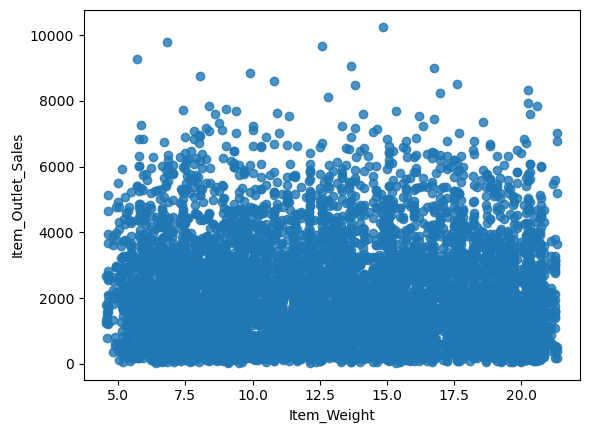

In [41]:
### there is no relation btween the sales and item weight 
### so the suitbale choice to fill it with the average weight
sns.regplot(x='Item_Weight',y='Item_Outlet_Sales',data=df)

In [42]:
df[['Item_Outlet_Sales','Item_Weight']].corr()

,Item_Outlet_Sales,Item_Weight
Item_Outlet_Sales,1.000000,0.011901
Item_Weight,0.011901,1.000000


In [43]:
df['Item_Weight'].fillna(df['Item_Weight'].mean(),inplace=True)
test_data['Item_Weight'].fillna(test_data['Item_Weight'].mean(),inplace=True)

# ----------------------------------------------------------------------------------------

## after the analysis and visualization of data we found

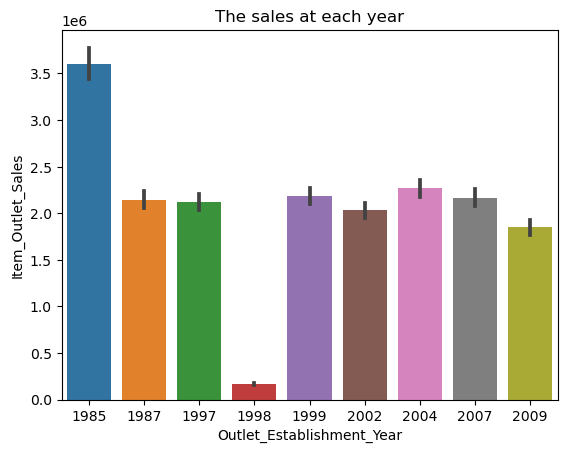

In [44]:
#  1- the total sales in each year 
# the max sales was in year 1985
sns.barplot(x=df['Outlet_Establishment_Year'],y=df['Item_Outlet_Sales'],estimator=sum)
plt.title('The sales at each year')
plt.show()

In [45]:
## 2- total sales of each item type 
# the most saled item was fruites and vegetables
df.groupby(['Item_Type'])['Item_Outlet_Sales'].sum()

Item_Type
Baking Goods             1.260140e+06
Breads                   5.522491e+05
Breakfast                2.311345e+05
Canned                   1.439663e+06
Dairy                    1.518133e+06
Frozen Foods             1.821346e+06
Fruits and Vegetables    2.812070e+06
Hard Drinks              4.573360e+05
Health and Hygiene       1.044006e+06
Household                2.049569e+06
Meat                     9.156561e+05
Others                   3.252599e+05
Seafood                  1.483749e+05
Snack Foods              2.727275e+06
Soft Drinks              8.903317e+05
Starchy Foods            3.492754e+05
Name: Item_Outlet_Sales, dtype: float64

In [46]:
# 3-the total saled item of each of item type and the fat saturation
grouped=df.groupby(['Item_Type','Item_Fat_Content'])['Item_Outlet_Sales'].sum()
grouped

Item_Type              Item_Fat_Content
Baking Goods           lf                  5.779064e+05
                       reg                 6.822333e+05
Breads                 lf                  3.047280e+05
                       reg                 2.475211e+05
Breakfast              lf                  9.865425e+04
                       reg                 1.324802e+05
Canned                 lf                  7.487633e+05
                       reg                 6.909000e+05
Dairy                  lf                  8.947080e+05
                       reg                 6.234245e+05
Frozen Foods           lf                  9.525214e+05
                       reg                 8.688244e+05
Fruits and Vegetables  lf                  1.370605e+06
                       reg                 1.441466e+06
Hard Drinks            lf                  4.573360e+05
Health and Hygiene     lf                  1.044006e+06
Household              lf                  2.049569e+06
Meat    

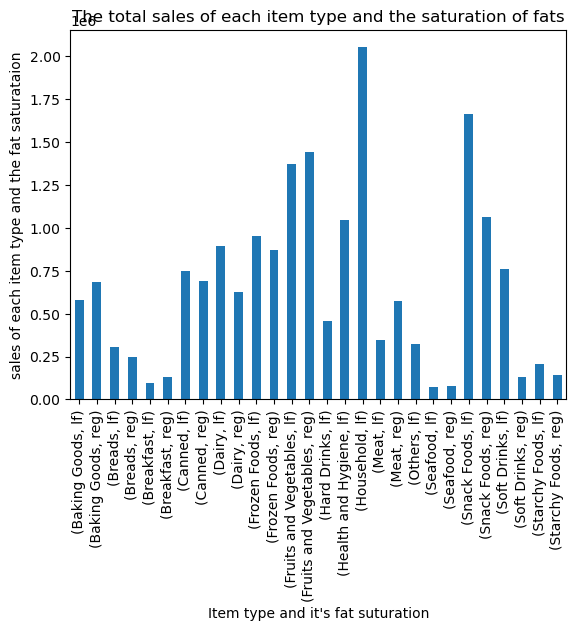

In [47]:
grouped.plot(kind='bar')
plt.xlabel("Item type and it's fat suturation")
plt.ylabel('sales of each item type and the fat saturataion')
plt.title('The total sales of each item type and the saturation of fats')
plt.show()

In [48]:
# 4-the mean of the max retail price for each product
df.groupby(['Item_Type'])['Item_MRP'].mean().sort_values(ascending=False)

Item_Type
Household                149.091689
Dairy                    148.369931
Starchy Foods            147.075715
Snack Foods              146.315087
Fruits and Vegetables    144.718491
Breakfast                143.046849
Breads                   141.615280
Seafood                  140.673970
Meat                     140.008138
Canned                   139.696943
Frozen Foods             138.441213
Hard Drinks              137.119116
Others                   133.242430
Soft Drinks              130.624270
Health and Hygiene       130.561362
Baking Goods             126.762213
Name: Item_MRP, dtype: float64

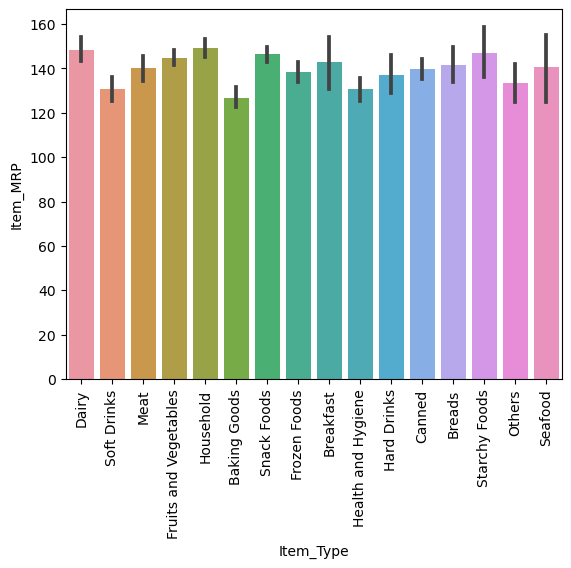

In [49]:
sns.barplot(x=df['Item_Type'],y=df['Item_MRP'])
plt.xticks(rotation=90)
plt.show()

In [50]:
# we find that the outlet that has id OUT027 has the maximium sales
df.groupby(df['Outlet_Identifier'])['Item_Outlet_Sales'].sum()

Outlet_Identifier
OUT010    1.665539e+05
OUT013    2.142664e+06
OUT017    2.167465e+06
OUT018    1.851823e+06
OUT019    1.521746e+05
OUT027    3.453926e+06
OUT035    2.268123e+06
OUT045    2.036725e+06
OUT046    2.118395e+06
OUT049    2.183970e+06
Name: Item_Outlet_Sales, dtype: float64

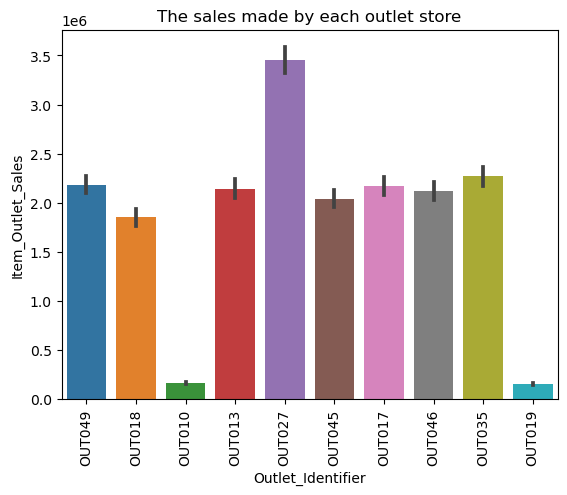

In [51]:
sns.barplot(x=df['Outlet_Identifier'],y=df['Item_Outlet_Sales'],estimator=sum)
plt.xticks(rotation=90)
plt.title('The sales made by each outlet store')
plt.show()

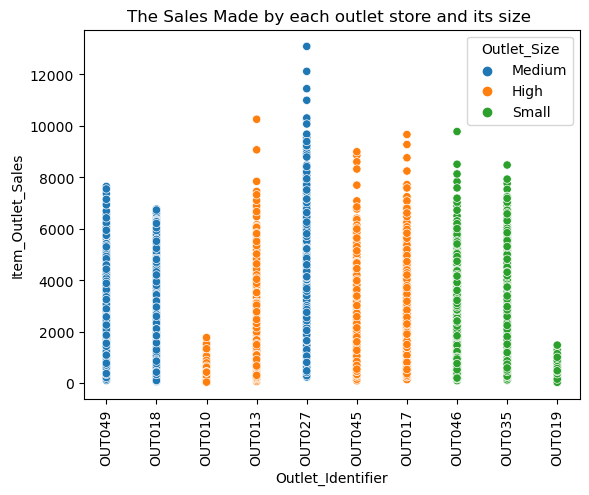

In [52]:
sns.scatterplot(x=df['Outlet_Identifier'],y=df['Item_Outlet_Sales'],hue=df['Outlet_Size'])
plt.xticks(rotation=90)
plt.title('The Sales Made by each outlet store and its size ')
plt.show()

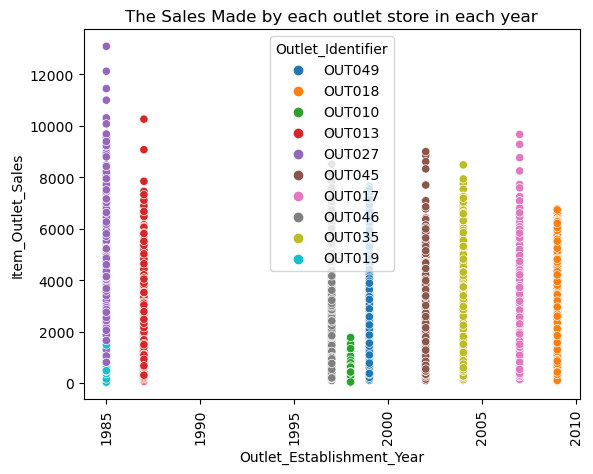

In [53]:
sns.scatterplot(x=df['Outlet_Establishment_Year'],y=df['Item_Outlet_Sales'],hue=df['Outlet_Identifier'])
plt.title('The Sales Made by each outlet store in each year')
plt.xticks(rotation=90)
plt.show()


In [54]:
df.groupby(['Item_Identifier','Outlet_Identifier'])['Item_Outlet_Sales'].sum().sort_values(ascending=False)
## we notice that the item that is selling most is 'NCE42' in OUT027

Item_Identifier  Outlet_Identifier
NCE42            OUT027               13086.9648
FDQ19            OUT027               12117.5600
FDZ20            OUT027               11445.1020
FDP33            OUT027               10993.6896
FDI50            OUT027               10306.5840
                                         ...    
FDS40            OUT019                  36.6190
NCL41            OUT019                  34.6216
FDU21            OUT019                  33.9558
DRK12            OUT010                  33.2900
NCR42            OUT010                  33.2900
Name: Item_Outlet_Sales, Length: 8379, dtype: float64

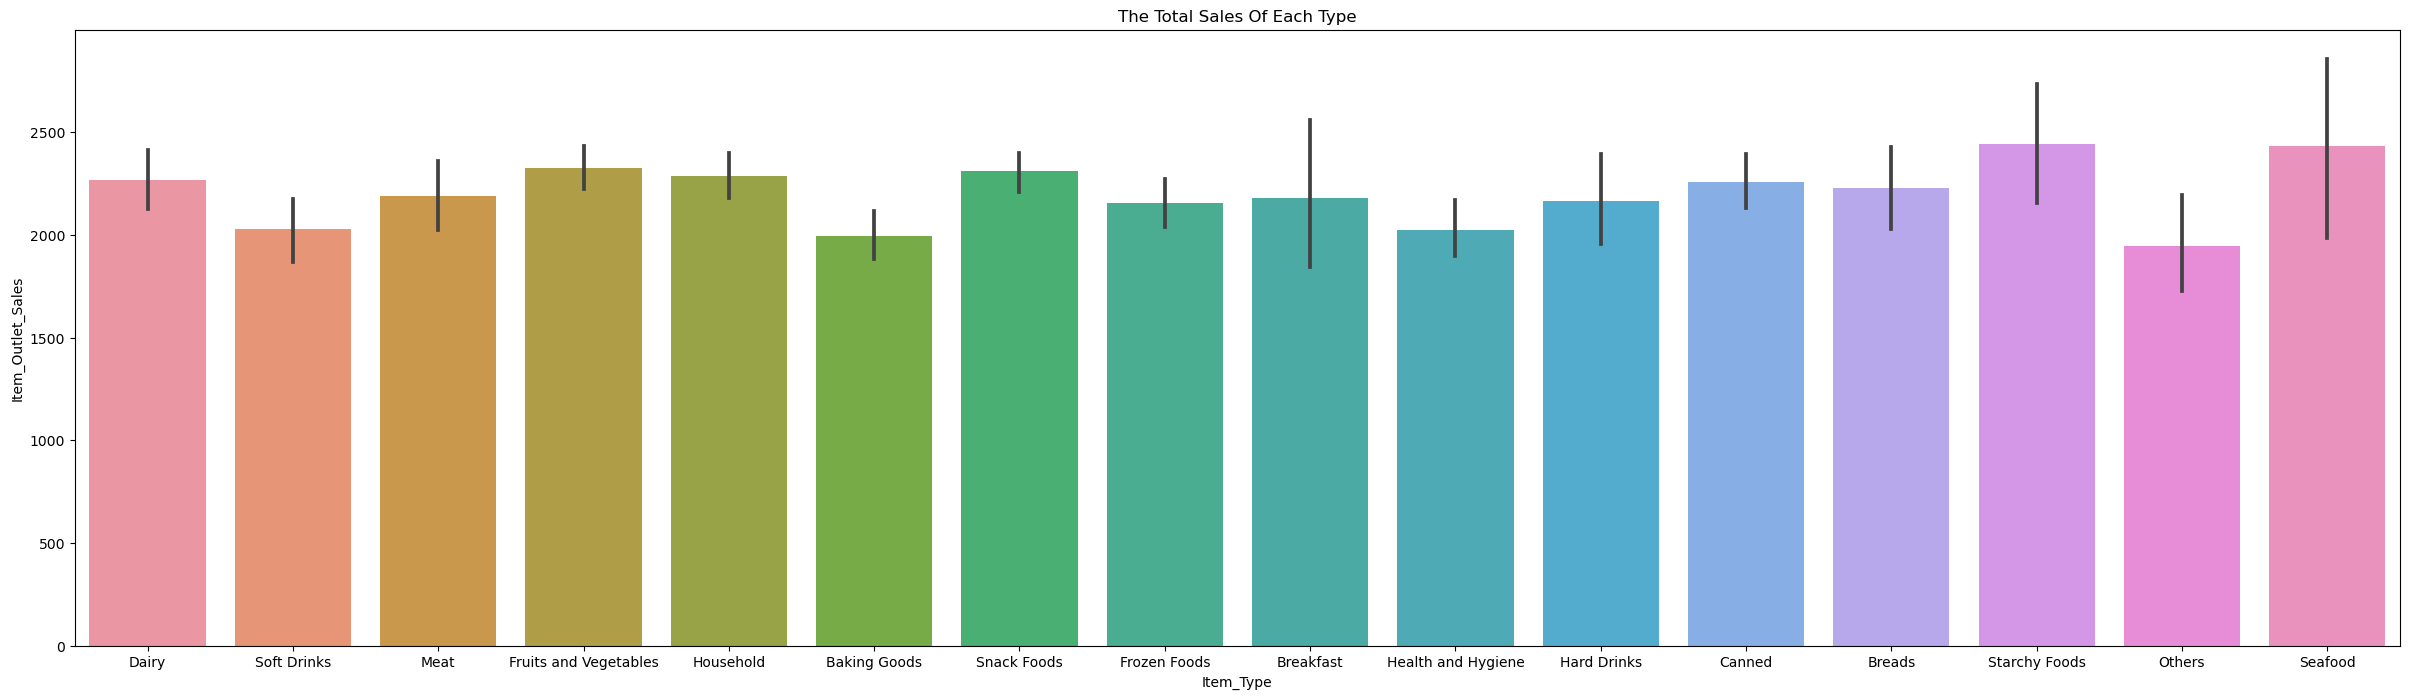

In [55]:
plt.figure(figsize=(30,8))
sns.barplot(x=df['Item_Type'],y=df['Item_Outlet_Sales'],e)
plt.title('The Total Sales Of Each Type')
plt.show()
## we notice that 

# ------------------------------------------------------------------------------------------------

In [56]:
# split the train data
X=df.drop(columns=['Item_Outlet_Sales','Outlet_Establishment_Year'],axis=1)
y=df['Item_Outlet_Sales']

In [57]:
scaler_Robust=RobustScaler()
scaler_minmax=MinMaxScaler()
scaler_standered=StandardScaler()

In [58]:
scaled_X_Robust=pd.DataFrame(scaler_Robust.fit_transform(X[['Item_Weight','Item_Visibility','Item_MRP','No_Establishment_Years']])
                             ,columns=['Item_Weight','Item_Visibility','Item_MRP','No_Establishment_Years'])
scaled_X_minmax=pd.DataFrame(scaler_minmax.fit_transform(X[['Item_Weight','Item_Visibility','Item_MRP','No_Establishment_Years']])
                             ,columns=['Item_Weight','Item_Visibility','Item_MRP','No_Establishment_Years'])
scaled_X_standered=pd.DataFrame(scaler_standered.fit_transform(X[['Item_Weight','Item_Visibility','Item_MRP','No_Establishment_Years']]),
                                columns=['Item_Weight','Item_Visibility','Item_MRP','No_Establishment_Years'])

In [59]:
scaled_X_standered

,Item_Weight,Item_Visibility,Item_MRP,No_Establishment_Years
0,-0.840741,-1.187361,1.747925,-0.125905
1,-1.637582,-1.112493,-1.488702,-1.323226
2,1.092424,-1.170844,0.010431,-0.125905
3,1.493202,0.062577,0.660470,-0.006173
4,-0.927969,-0.121277,-1.398894,1.310880
...,...,...,...,...
8374,-1.414796,-0.243410,1.181228,1.310880
8375,-1.057632,-0.470521,-0.526935,-0.485102
8376,-0.534263,-0.743866,-0.896859,-0.724566
8377,-1.333462,1.805891,-0.607615,-1.323226


<AxesSubplot:title={'center':'after stander scaler'}, xlabel='Item_Weight', ylabel='Density'>

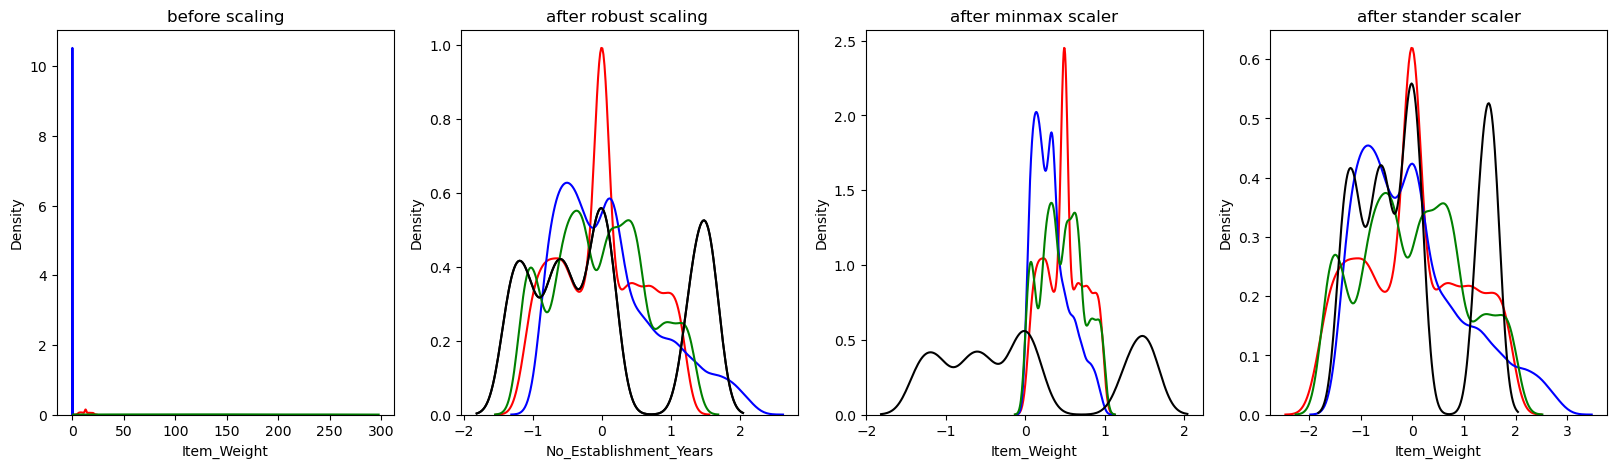

In [60]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(ncols=4,figsize =(20, 5))
ax1.set_title('before scaling')
sns.kdeplot(X['Item_Weight'],ax=ax1,color='r')
sns.kdeplot(X['Item_Visibility'],ax=ax1,color='b')
sns.kdeplot(X['Item_MRP'],ax=ax1,color='g')
sns.kdeplot(scaled_X_standered['No_Establishment_Years'],ax=ax2,color='black')
ax2.set_title('after robust scaling ')
sns.kdeplot(scaled_X_Robust['Item_Weight'],ax=ax2,color='r')
sns.kdeplot(scaled_X_Robust['Item_Visibility'],ax=ax2,color='b')
sns.kdeplot(scaled_X_Robust['Item_MRP'],ax=ax2,color='g')
sns.kdeplot(scaled_X_standered['No_Establishment_Years'],ax=ax2,color='black')

ax3.set_title('after minmax scaler')
sns.kdeplot(scaled_X_minmax['Item_Weight'],ax=ax3,color='r')
sns.kdeplot(scaled_X_minmax['Item_Visibility'],ax=ax3,color='b')
sns.kdeplot(scaled_X_minmax['Item_MRP'],ax=ax3,color='g')
sns.kdeplot(scaled_X_standered['No_Establishment_Years'],ax=ax3,color='black')

ax4.set_title('after stander scaler')
sns.kdeplot(scaled_X_standered['Item_Weight'],ax=ax4,color='r')
sns.kdeplot(scaled_X_standered['Item_Visibility'],ax=ax4,color='b')
sns.kdeplot(scaled_X_standered['Item_MRP'],ax=ax4,color='g')
sns.kdeplot(scaled_X_standered['No_Establishment_Years'],ax=ax4,color='black')
# the most scaled data with respect tothe plot is the after applying standard

In [61]:
# scaled test data 
scaled_test_data=pd.DataFrame(scaler_standered.fit_transform(test_data[['Item_Weight','Item_Visibility','Item_MRP','No_Establishment_Years']]),
                              columns=['Item_Weight','Item_Visibility','Item_MRP','No_Establishment_Years'])

# -----------------------------------------------------------------------------------------------

In [62]:
le=LabelEncoder()
cols_to_encode = ['Item_Identifier', 'Item_Type','Outlet_Identifier','Item_Fat_Content', 'Outlet_Size','Outlet_Location_Type','Outlet_Type']
for i in cols_to_encode:
    X[i]=le.fit_transform(X[i])

In [63]:
X.drop(['Item_Weight','Item_Visibility','Item_MRP',
        'No_Establishment_Years'],axis=1,inplace=True)
X=pd.merge(X,scaled_X_standered,left_index=True,right_index=True)


In [64]:
X.columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Weight',
       'Item_Visibility', 'Item_MRP', 'No_Establishment_Years'],
      dtype='object')

#  ------------------------------------------------------------------------------------

## Pipline 

In [65]:
model_scores = pd.DataFrame(columns=['model', 'rmse', 'r2_score','Mae'])
def train_and_evaluate_model(model_name, model, X, y):
    '''
    Create a training pipeline to scale and train the model
    using the input data, then evaluate the model and safe its error
    and score in the scores dataframe.
    '''
    # split the data
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # create a training pipeline
    pipeline = make_pipeline(StandardScaler(), model)
    
    # apply scaling on training data and train the model
    pipeline.fit(X_train, y_train)
    
    # predict the validation set
    y_hat = pipeline.predict(X_validate)
    
    # evaluate the model
    rmse = np.sqrt(mean_squared_error(y_validate, y_hat))
    model_score = r2_score(y_validate, y_hat)
    mae=mean_absolute_error(y_validate,y_hat)
    
    # adding error and score, to the scores datafrane
    model_scores.loc[len(model_scores)] = [model_name, rmse, model_score,mae]
    
    print('----------------------------------')
    print(model_name, ' Report:')
    print('----------------------------------')
    print('RMSE: ', rmse)
    print('R2 Score: ', model_score)
    print('Mae',mae)

## Apply GradientBoostingRegressor

In [66]:
param_grid = {
    'n_estimators': [50,100, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1],
    'subsample': [0.1,0.5, 0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Instantiate a Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Create a GridSearchCV object with the hyperparameters and the model
grid_search = GridSearchCV(gbr, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Print the best hyperparameters found
print(grid_search.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 0.8}


In [67]:
gb = GradientBoostingRegressor(n_estimators=50,learning_rate=0.1, max_depth=9,subsample=0.5,min_samples_split=2,random_state=0)
train_and_evaluate_model('GradientBoostingRegressor_GS',gb,X,y)

----------------------------------
GradientBoostingRegressor_GS  Report:
----------------------------------
RMSE:  1133.7332885406554
R2 Score:  0.5461050208013538
Mae 780.2670627632692


In [78]:
## try  to appply the parameters from grid search 
gb = GradientBoostingRegressor(n_estimators=500,learning_rate=0.01, max_depth=3,subsample=0.8,min_samples_split=10,random_state=0)
train_and_evaluate_model('GradientBoostingRegressor_GS2',gb,X,y)

----------------------------------
GradientBoostingRegressor_GS2  Report:
----------------------------------
RMSE:  1072.7163584326663
R2 Score:  0.5936470764698218
Mae 744.606157069743


## Apply RandomForestRegressor

In [68]:
# Define the hyperparameters to tune and their possible values
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Instantiate a random forest 
rfc = RandomForestRegressor()

# Create a GridSearchCV object with the hyperparameters and the model
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X,y)
# Print the best hyperparameters found
print(grid_search.best_params_)

{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [69]:
## apply rondom forest
model=RandomForestRegressor(n_estimators=50,min_samples_split=5,max_depth=5,random_state=1)

In [70]:
train_and_evaluate_model('Randomforestregressor',model,X,y)

----------------------------------
Randomforestregressor  Report:
----------------------------------
RMSE:  1076.771311363059
R2 Score:  0.5905691775214955
Mae 745.4604581186564


In [79]:
### apply the paraemeter from grid search
model=RandomForestRegressor(n_estimators=100,min_samples_split=5,max_depth=5,random_state=0)
train_and_evaluate_model('Randomforestregressor_GS',model,X,y)

----------------------------------
Randomforestregressor_GS  Report:
----------------------------------
RMSE:  1076.6499002022729
R2 Score:  0.5906615029176178
Mae 745.4357079170619


### Apply Linear Regression

In [71]:
lr = LinearRegression()

# Define the hyperparameters to tune and their possible values
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Create a GridSearchCV object with the hyperparameters and the model
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Print the best hyperparameters found
print(grid_search.best_params_)

{'fit_intercept': True, 'normalize': True}


In [72]:
lr=LinearRegression(fit_intercept=True,normalize=True,random_state=0)
train_and_evaluate_model('LinearRegression',lr,X,y)

----------------------------------
LinearRegression  Report:
----------------------------------
RMSE:  1183.1695011481406
R2 Score:  0.505657995609847
Mae 879.419689856872


## Apply XGBoost

In [73]:
xgb=XGBRegressor(random_state=0)

In [74]:

train_and_evaluate_model("XGBoost",xgb,X,y)

----------------------------------
XGBoost  Report:
----------------------------------
RMSE:  1155.0780548676591
R2 Score:  0.528853198203351
Mae 802.916531172881


## Apply Lasso 

In [75]:
lasso=Lasso(alpha=0.1,random_state=0)
train_and_evaluate_model('Lasso',lasso,X,y)

----------------------------------
Lasso  Report:
----------------------------------
RMSE:  1183.1628759309867
R2 Score:  0.5056635317802006
Mae 879.4008257224991


## Ridge 

In [76]:
ridge=Ridge(random_state=0 
           )
train_and_evaluate_model('Rigde',ridge,X,y)

----------------------------------
Rigde  Report:
----------------------------------
RMSE:  1183.1666238146097
R2 Score:  0.5056603999738778
Mae 879.404023738632


In [80]:
model_scores

,model,rmse,r2_score,Mae
0,GradientBoostingRegressor_GS,1133.733289,0.546105,780.267063
1,Randomforestregressor,1076.771311,0.590569,745.460458
2,LinearRegression,1183.169501,0.505658,879.419690
3,XGBoost,1155.078055,0.528853,802.916531
4,Lasso,1183.162876,0.505664,879.400826
5,Rigde,1183.166624,0.505660,879.404024
6,GradientBoostingRegressor_GS2,1072.716358,0.593647,744.606157
7,Randomforestregressor_GS,1076.649900,0.590662,745.435708


## As shown in the previous table the best model give lowest rmse and mae is the GradienBoostingRegresor with the GridSearch hyperparameter


In [81]:
test_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,No_Establishment_Years
0,FDW58,20.750000,lf,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,14
1,FDW14,8.300000,reg,0.038428,Dairy,87.3198,OUT017,2007,High,Tier 2,Supermarket Type1,6
2,NCN55,14.600000,lf,0.099575,Others,241.7538,OUT010,1998,High,Tier 3,Grocery Store,15
3,FDQ58,7.315000,lf,0.015388,Snack Foods,155.0340,OUT017,2007,High,Tier 2,Supermarket Type1,6
4,FDY38,12.697306,reg,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,28
...,...,...,...,...,...,...,...,...,...,...,...,...
5563,FDB58,10.500000,reg,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,16
5564,FDD47,7.600000,reg,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,4
5565,NCO17,10.000000,lf,0.073529,Health and Hygiene,118.7440,OUT045,2002,High,Tier 2,Supermarket Type1,11
5566,FDJ26,15.300000,reg,0.068816,Canned,214.6218,OUT017,2007,High,Tier 2,Supermarket Type1,6


## Applying encoding to the testdata and merge it with scaled columns

In [84]:
le=LabelEncoder()
cols_to_encode = ['Item_Identifier', 'Item_Type','Outlet_Identifier','Item_Fat_Content', 'Outlet_Size','Outlet_Location_Type','Outlet_Type']
for i in cols_to_encode:
    test_data[i]=le.fit_transform(test_data[i])

In [86]:
test_data.drop(['Item_Weight','Item_Visibility','Item_MRP',
        'No_Establishment_Years','Outlet_Establishment_Year'],axis=1,inplace=True)


In [89]:
test_data=pd.merge(test_data,scaled_test_data,left_index=True,right_index=True)

In [91]:
gb = GradientBoostingRegressor(n_estimators=500,learning_rate=0.01, max_depth=3,subsample=0.8,min_samples_split=10,random_state=0)
gb.fit(X,y)
test_data_pred=gb.predict(test_data)

In [93]:
pd.DataFrame(test_data_pred,columns=['Target']).to_csv('Output_Results_from_GradientBoosting.csv',index=False)